There is some problem with the translocations, namely TRA_start and TRA_end are seen by the NN as essentially the same category. See the ver_2 of this notebook for at NN that treats them as one category, the accuracy there is 97.8%. 

## Load dependences and setting output configuration

In [51]:
import numpy as np
from keras.utils.np_utils import to_categorical
import keras
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\sonja\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Load labels from npy files

In [52]:
datapath = "F:/1_GTCG/data/081018/TrainingData_081018/"
sv_types = ["DUP","INDEL", "INV", "TRA"]

#germline_1_datapath = datapath + 'G1/ChannelData/'
#ger_1_labels_datapath = datapath + 'G1/LabelData/'
#G1_data = np.empty([0, 38, 200])


def loadSVData(sv_types, datapath):
    G1_data = {}
    G1_labels ={}
    for sv_type in sv_types:
        if sv_type != 'TRA':
            G1_data[sv_type] =np.load(datapath +  "/" + sv_type + '/G1/ChannelData/G1.npy')
            G1_labels[sv_type] = np.load(datapath +  "/" + sv_type + '/G1/LabelData/G1_17_label.npy') 
        else:
            G1_data[sv_type] =np.load(datapath +  "/" + sv_type + '/G1/ChannelData/G1.npy')
            G1_labels[sv_type] = np.load(datapath +  "/" + sv_type + '/G1/LabelData/G1_12_label.npy') 
        print(sv_type + ':' + str(G1_data[sv_type].shape))
        print(G1_data[sv_type][0])
    return G1_data, G1_labels    

In [53]:
def loadNoSVData(datapath):
    N1_data=np.load(datapath +  "/DUP"  + '/N1/ChannelData/17_channel_maker_real_germline.npy')
    N1_labels = np.load(datapath +  "/DUP" + '/N1/LabelData/N1_17_label.npy')         
    print("NoSV" + ':' + str(N1_data.shape))
    print(N1_data[0])
    return N1_data, N1_labels

In [54]:
G1_data, G1_labels = loadSVData(sv_types, datapath)

DUP:(9636, 38, 50)
[[ 49.  48.  50. ...,  74.  80.  79.]
 [  0.   0.   0. ...,   0.   0.   0.]
 [  0.   0.   0. ...,   0.   0.   0.]
 ..., 
 [ 20.  20.  20. ...,  60.  60.  60.]
 [  1.   1.   1. ...,   1.   1.   1.]
 [  0.   0.   0. ...,   0.   0.   0.]]
INDEL:(19417, 38, 50)
[[ 51.  55.  50. ...,  28.  27.  27.]
 [  0.   0.   0. ...,   0.   0.   0.]
 [  0.   0.   0. ...,   0.   0.   0.]
 ..., 
 [ 60.  60.  40. ...,  20.  20.  20.]
 [  1.   1.   1. ...,   1.   1.   1.]
 [  0.   0.   0. ...,   0.   0.   0.]]
INV:(38502, 38, 50)
[[ 36.  38.  39. ...,  45.  46.  43.]
 [  0.   0.   0. ...,   0.   0.   0.]
 [  0.   0.   0. ...,   0.   0.   0.]
 ..., 
 [ 40.  40.  40. ...,  20.  20.  20.]
 [  1.   1.   1. ...,   1.   1.   1.]
 [  0.   0.   0. ...,   0.   0.   0.]]
TRA:(72480, 38, 50)
[[ 41.  42.  41. ...,  40.  40.  38.]
 [  0.   0.   0. ...,   0.   0.   0.]
 [  0.   0.   0. ...,   0.   0.   0.]
 ..., 
 [ 60.  60.  60. ...,  80.  80.  40.]
 [  1.   1.   1. ...,   1.   1.   1.]
 [  0.   0.   

In [55]:
N1_data, N1_labels = loadNoSVData(datapath)

NoSV:(19960, 38, 50)
[[ 24.  24.  24. ...,  29.  28.  27.]
 [  0.   0.   0. ...,   0.   0.   0.]
 [  0.   0.   0. ...,   0.   0.   0.]
 ..., 
 [ 60.  60.  60. ...,  20.  20.  20.]
 [  1.   1.   1. ...,   1.   1.   1.]
 [  0.   0.   0. ...,   0.   0.   0.]]


### Find  the indexes that split the categories

In [56]:
def find_splitting_indices(labels):
    for i in range (0, labels.shape[0] - 1):
        if (labels[i] != labels[i+1]):
            print(i , ': ', labels[i] , labels[i+1] )        

In [57]:
find_splitting_indices(G1_labels["DUP"])

4820 :  DUP_start DUP_end


In [58]:
find_splitting_indices(G1_labels["INDEL"])

4697 :  DEL_start DEL_end
9377 :  DEL_end INS_pos


In [59]:
find_splitting_indices(G1_labels["INV"])

19242 :  INV_start INV_end


In [60]:
find_splitting_indices(G1_labels["TRA"])

36222 :  TRA_start TRA_end


In [61]:
class_size = 4680
X_DUP_start =  G1_data["DUP"][0:class_size]
X_DUP_end =  G1_data["DUP"][4821:4821+class_size]
X_DEL_start = G1_data["INDEL"][0: class_size]
X_DEL_end = G1_data["INDEL"][4698: 4698+ class_size]
X_INS_pos = G1_data["INDEL"][9378: 9378+ class_size]
X_INV_start = G1_data["INV"][0: class_size]
X_INV_end = G1_data["INV"][19243: 19243 + class_size]
X_TRA_start = G1_data["TRA"][0: class_size]
X_TRA_end = G1_data["TRA"][36223:36223+ class_size]

In [62]:

y_DUP_start =  G1_labels["DUP"][0:class_size]
y_DUP_end =  G1_labels["DUP"][4821:4821+class_size]
y_DEL_start = G1_labels["INDEL"][0: class_size]
y_DEL_end = G1_labels["INDEL"][4698: 4698+ class_size]
y_INS_pos = G1_labels["INDEL"][9378: 9378+ class_size]
y_INV_start = G1_labels["INV"][0: class_size]
y_INV_end = G1_labels["INV"][19243: 19243 + class_size]
y_TRA_start = G1_labels["TRA"][0: class_size]
y_TRA_end = G1_labels["TRA"][36223:36223+ class_size]

## Split into training, validation and test labelssets

In [63]:
def ConcatAllCategories(start, end):    
    X= np.concatenate((X_DUP_start[start:end], X_DUP_end[start:end], X_DEL_start[start:end], X_DEL_end[start:end], X_INS_pos[start:end],X_INV_start[start:end], X_INV_end[start:end], X_TRA_start[start:end], X_TRA_end[start:end], N1_data[start:end]   ))
    y= np.concatenate((y_DUP_start[start:end], y_DUP_end[start:end], y_DEL_start[start:end], y_DEL_end[start:end], y_INS_pos[start:end],y_INV_start[start:end], y_INV_end[start:end], y_TRA_start[start:end], y_TRA_end[start:end], N1_labels[start:end]   ))
    return X, y

In [64]:
X_train, y_train = ConcatAllCategories(0, int(2*class_size/3))
X_val, y_val =     ConcatAllCategories(int(2*class_size/3), int(5*class_size/6) )
X_test, y_test =   ConcatAllCategories(int(5*class_size/6), class_size )

In [65]:
G1_data = []
N1_data = []

In [66]:
G1_labels = []
N1_labels = []

### Number of training, validation and test windows

In [67]:
X_train.shape

(31200, 38, 50)

In [68]:
X_val.shape

(7800, 38, 50)

In [69]:
X_test.shape

(7800, 38, 50)

In [70]:
y_test.shape

(7800,)

In [71]:
number_channels = X_train.shape[1]
number_channels

38

## Normalize labels using the reads coverage as parameter

In [72]:
coverage = np.median(X_train[:, 0, :]) #the median of the coverage in the normal cells
coverage


43.0

In [73]:
def normalize(X):       
    for i in range (0, len(X)):                              
        for j in range(0,number_channels):                                                                                            
            X[i][j] = np.divide(X[i][j], coverage)*100 
normalize(X_train)
normalize(X_val)
normalize(X_test)


In [74]:
def eliminate_noise_chanels(X):
    #return np.delete(X, [8-1,9-1,10-1,11-1, 12-1,13-1, 14-1, 15-1,16-1, 17-1,18-1,19-1,21-1, 22-1, 23-1,24-1, 27,28,29,30,31,32], axis=1)
    return np.take(X, [0,1,2,3,4,5,6, 7,8, 27,28], axis = 1)

In [75]:
X_train = eliminate_noise_chanels(X_train)
X_val = eliminate_noise_chanels(X_val)
X_test = eliminate_noise_chanels(X_test)

In [76]:
X_train.shape

(31200, 11, 50)

In [77]:
number_channels = X_train.shape[1]
number_channels

11

## Plots several  windows from the somatic SV category

In [78]:
n_windows = 30
label = ["None"] * number_channels

In [79]:
from numpy import *
import math
import matplotlib.pyplot as plt

colors =['b','g', 'm', 'gray', 'r','c', 'darkgreen' ,'y', 'k', 'orange', 'gray']

def plot_channels(start_window, n_windows):
    for i in range (start_window, start_window + n_windows, 5):
        print(y_train[i], 'id:', i)
        print('id:', i)
        for j in range (0, number_channels):   
            shift = 0
            start =0
            if j in [0,11]:
                shift = -100
            if j > 8:
                start = -60
            Z = [start + shift + 300 + x - 5*j*4 for x in X_train[i][j]]  
            #plt.ylim([100,700])
            if np.max(Z) > 1000:
                plt.ylim([-200,1000])
                Z = [start + shift + 300 + x - 5*j*4 - 400 for x in X_train[i][j]]  
            if j>8:
                plt.plot(Z,  label = label[j], linestyle=':', linewidth=1.5, color = colors[j % 9])
            else:
                plt.plot(Z, label = label[j], color = colors[j])
        
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 10})    
        plt.show()

DUP_start id: 0
id: 0


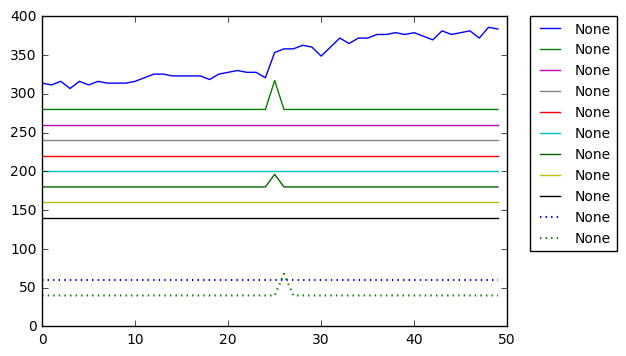

DUP_start id: 5
id: 5


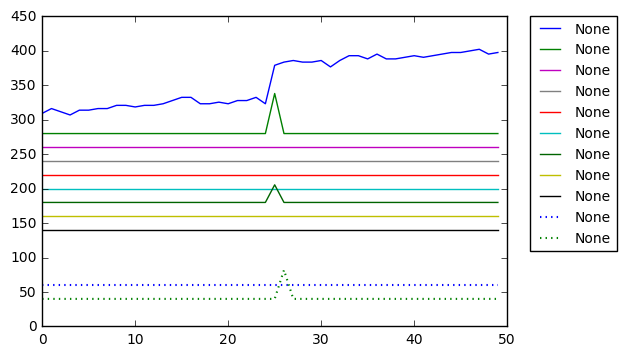

DUP_start id: 10
id: 10


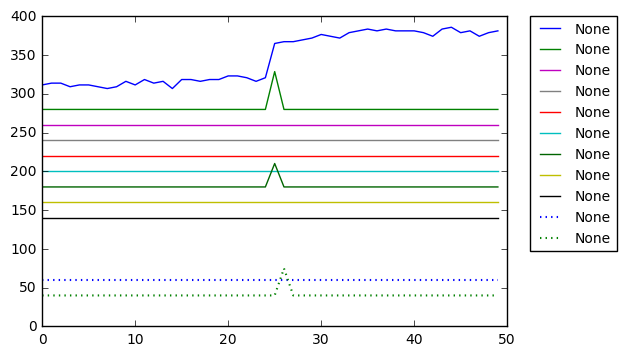

DUP_start id: 15
id: 15


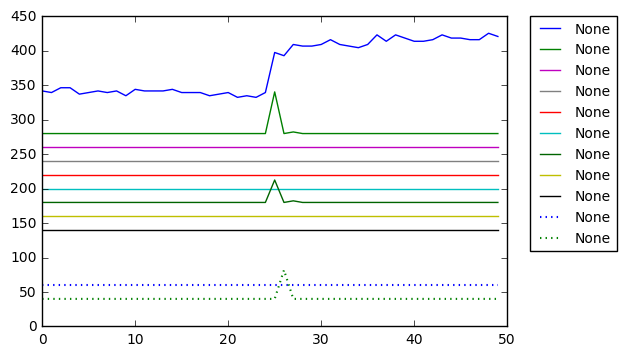

DUP_start id: 20
id: 20


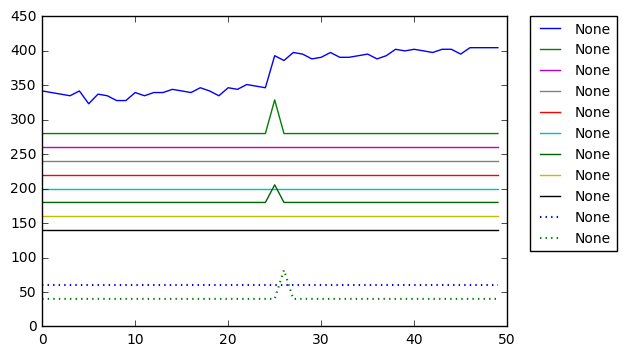

DUP_start id: 25
id: 25


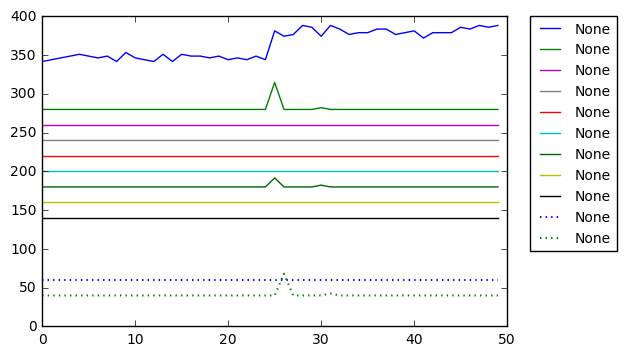

In [80]:
start_window = 0
plot_channels(start_window, n_windows)

DUP_start id: 3000
id: 3000


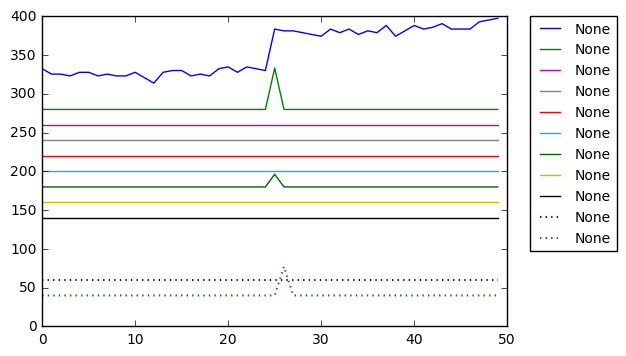

DUP_start id: 3005
id: 3005


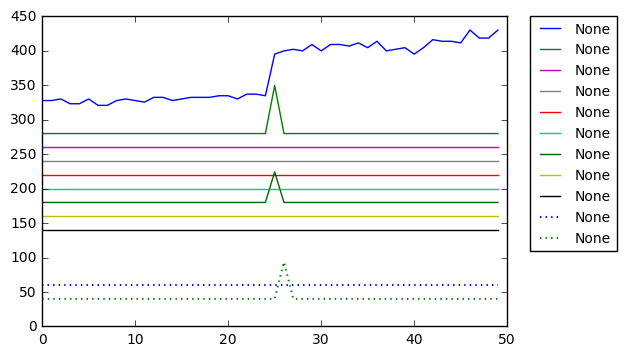

DUP_start id: 3010
id: 3010


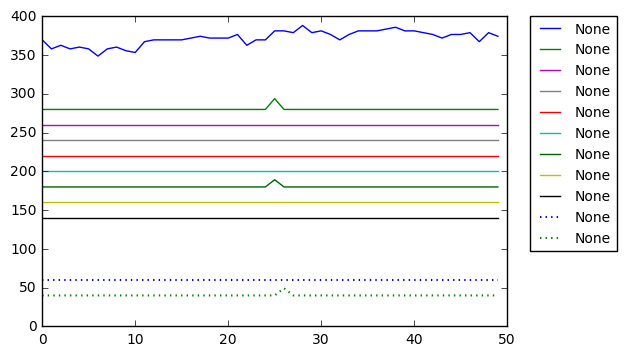

DUP_start id: 3015
id: 3015


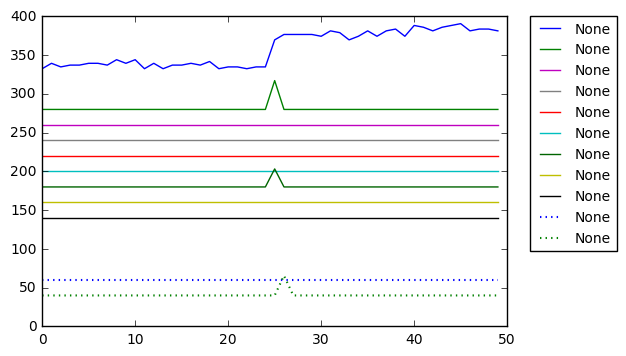

DUP_start id: 3020
id: 3020


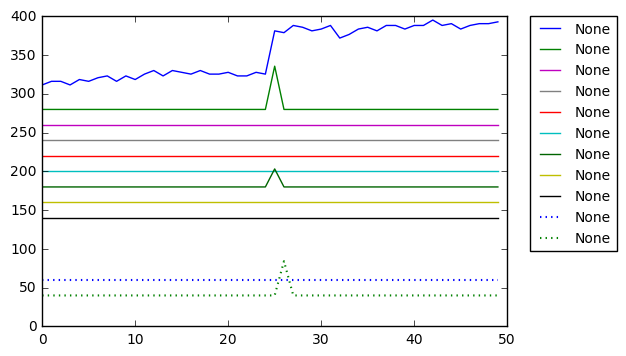

DUP_start id: 3025
id: 3025


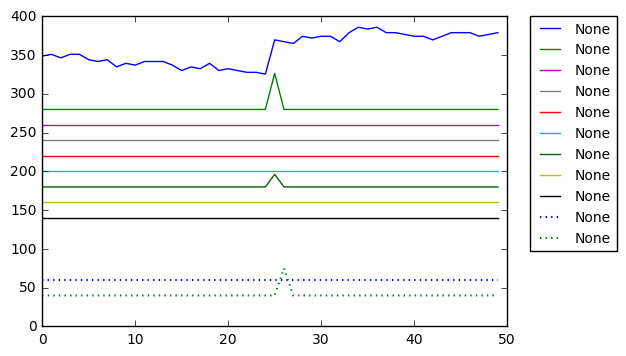

In [81]:
start_window =3000
plot_channels(start_window, n_windows)

DUP_end id: 6000
id: 6000


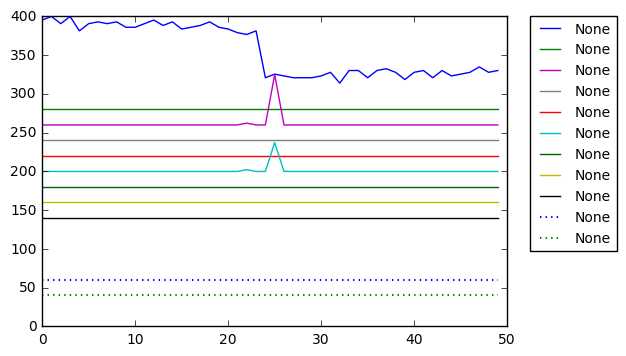

DUP_end id: 6005
id: 6005


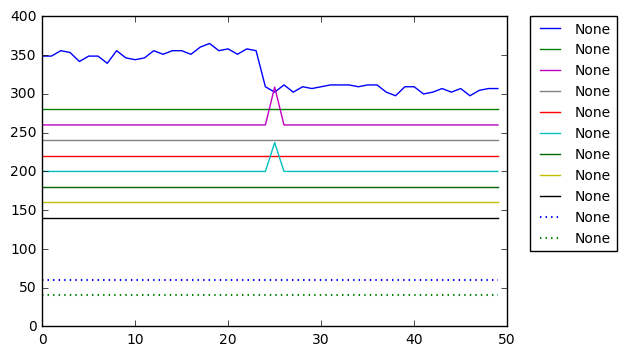

DUP_end id: 6010
id: 6010


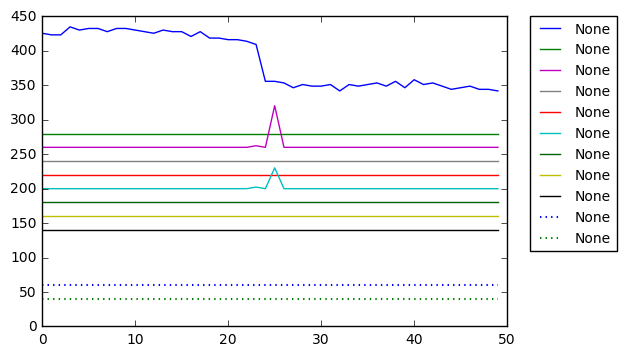

DUP_end id: 6015
id: 6015


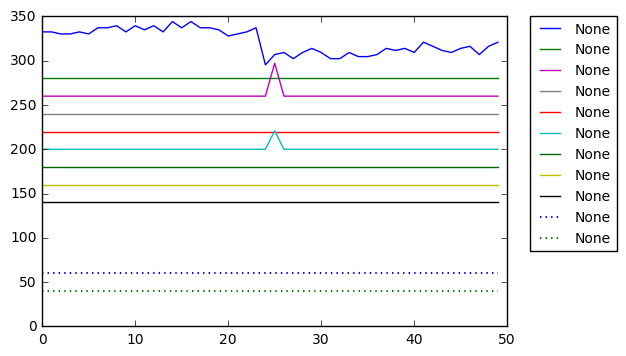

DUP_end id: 6020
id: 6020


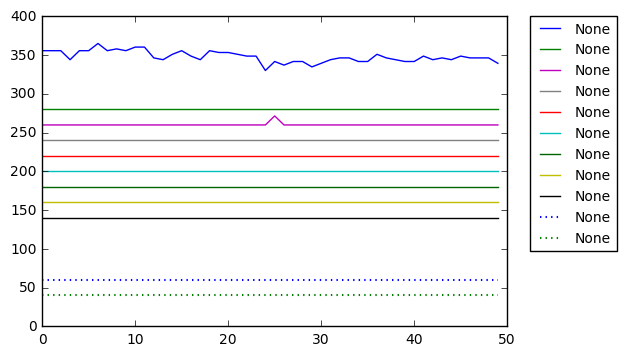

DUP_end id: 6025
id: 6025


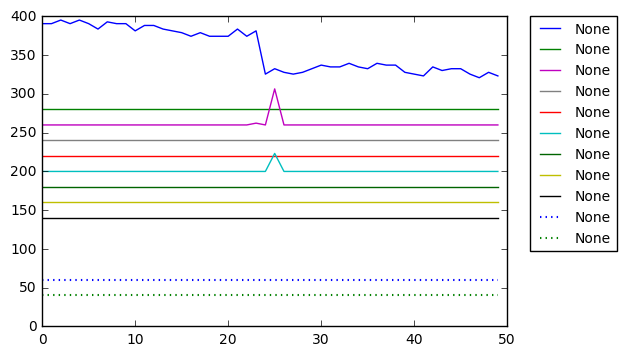

In [82]:
start_window =6000
plot_channels(start_window, n_windows)

   
## Transposes every window in X, to comply to McFly format

In [83]:
def transposelabelsset(X):
    image = []
    for i in range (0, len(X -1)):
        tr = X[i].transpose()
        image.append(tr)
    return np.array(image)

image1 = transposelabelsset(X_train)
image2 = transposelabelsset(X_val)
image3 = transposelabelsset(X_test)
X_train = image1
X_val = image2
X_test = image3

n_channels = len(X_train[0][0])
print(len(X_test[0][0]))

11


## Prepare the labels in McFly format

In [84]:
classlabels = list(set(y_train))
mapclasses = {classlabels[i] : i for i in range(len(classlabels))}
print(mapclasses)

y_train = np.array([mapclasses[c] for c in y_train], dtype='int')
y_val = np.array([mapclasses[c] for c in y_val], dtype='int')
y_test = np.array([mapclasses[c] for c in y_test], dtype='int')
y_train_binary = to_categorical(y_train)
y_val_binary = to_categorical(y_val)
y_test_binary = to_categorical(y_test)

{'TRA_start': 9, 'DUP_end': 0, 'DEL_end': 2, 'DEL_start': 7, 'DUP_start': 6, 'INV_end': 1, 'TRA_end': 8, 'INS_pos': 3, 'INV_start': 4, 'noSV': 5}


In [85]:
y_test_binary

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [86]:
y_val_binary


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [87]:
X_train.shape

(31200, 50, 11)

## Generate neural networks architectures

In [88]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, MaxPooling1D
from keras.optimizers import Adam
import sys
import os
import numpy as np
sys.path.insert(0, os.path.abspath('..'))
from mcfly import modelgen, find_architecture

In [89]:
np.random.seed = 321
num_classes = y_train_binary.shape[1]

In [103]:
%%time
models = modelgen.generate_models(X_train.shape,
                                  num_classes,
                                  number_of_models = 4,
                                  model_type = 'CNN',
                                  cnn_min_layers=1,
                                  cnn_max_layers=1,
                                  cnn_min_filters = 12, 
                                  cnn_max_filters = 12, 
                                  cnn_min_fc_nodes=6, 
                                  cnn_max_fc_nodes=6,
                                  low_lr=1.7, high_lr=2,
                                  kernel_size = 5)

Wall time: 4.51 s


In [104]:
%%time
for model, params, model_types in models:
    print(params)
    model.summary()

{'kernel_size': 5, 'learning_rate': 0.015962641992285385, 'regularization_rate': 0.0003474618934822603, 'filters': array([12]), 'fc_hidden_nodes': 6}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_18 (Batc (None, 50, 11)            44        
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 50, 12)            672       
_________________________________________________________________
batch_normalization_19 (Batc (None, 50, 12)            48        
_________________________________________________________________
activation_18 (Activation)   (None, 50, 12)            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 600)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 360

## Train the networks

In [105]:
train_set_size = X_train.shape[0]
train_set_size

31200

In [106]:
%%time
histories, val_accuracies, val_losses = find_architecture.train_models_on_samples(X_train, y_train_binary,
                                                                                 X_val, y_val_binary,
                                                                                 models,nr_epochs=1, 
                                                                                  subset_size=train_set_size,
                                                                                  verbose=True)

Training model 0 CNN
Train on 31200 samples, validate on 7800 samples
Epoch 1/1
31200/31200 [==============================] - 18s 592us/step - loss: 0.5862 - acc: 0.8138 - val_loss: 0.3275 - val_acc: 0.8809
Training model 1 CNN
Train on 31200 samples, validate on 7800 samples
Epoch 1/1
31200/31200 [==============================] - 18s 573us/step - loss: 0.5046 - acc: 0.8554 - val_loss: 0.5469 - val_acc: 0.8331
Training model 2 CNN
Train on 31200 samples, validate on 7800 samples
Epoch 1/1
31200/31200 [==============================] - 16s 502us/step - loss: 0.6767 - acc: 0.8381 - val_loss: 5.2649 - val_acc: 0.3677
Training model 3 CNN
Train on 31200 samples, validate on 7800 samples
Epoch 1/1
31200/31200 [==============================] - 17s 544us/step - loss: 0.4302 - acc: 0.8607 - val_loss: 1.2849 - val_acc: 0.6423
Wall time: 1min 17s


## Plot training process

Currently run with a very low number of epochs

Wall time: 131 ms


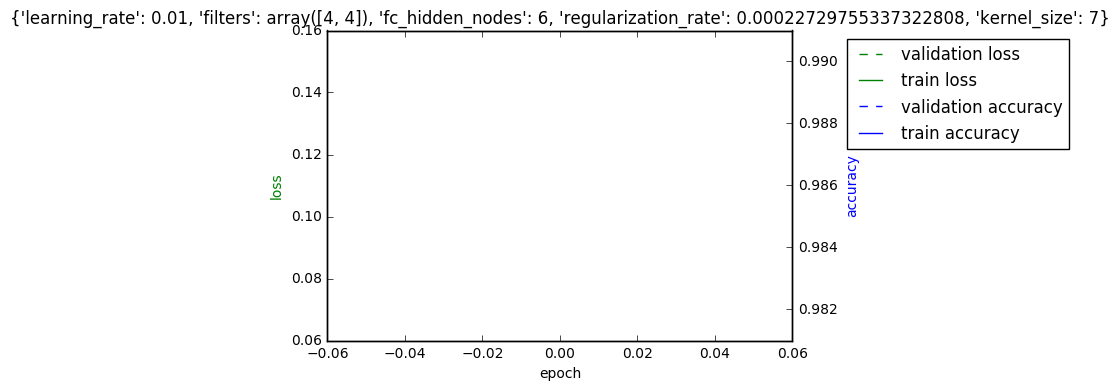

In [292]:
%%time
for i in range(len(models)):
    name = str(models[i][1])
    find_architecture.plotTrainingProcess(histories[i], name)

In [117]:
#%%time
import pandas as pd
results = pd.DataFrame({'model':[str(params) for model, params, model_types in models],
                       'train_acc': [history.history['acc'][-1] for history in histories],
                       'train_loss': [history.history['loss'][-1] for history in histories],
                       'val_acc': [history.history['val_acc'][-1] for history in histories],
                       'val_loss': [history.history['val_loss'][-1] for history in histories]
                       })
results

,model,train_acc,train_loss,val_acc,val_loss
0,"{'kernel_size': 5, 'learning_rate': 0.01596264...",0.813782,0.586216,0.880897,0.327526
1,"{'kernel_size': 5, 'learning_rate': 0.01276314...",0.855353,0.504610,0.833077,0.546929
2,"{'kernel_size': 5, 'learning_rate': 0.01855314...",0.838141,0.676660,0.367692,5.264900
3,"{'kernel_size': 5, 'learning_rate': 0.01660970...",0.860737,0.430165,0.642308,1.284895


## Take the best current model 

In [107]:
best_model_index = np.argmax(val_accuracies)

In [108]:
best_model, best_params, best_model_types = models[best_model_index]
print(best_model_index, best_model_types, best_params)

0 CNN {'kernel_size': 5, 'learning_rate': 0.015962641992285385, 'regularization_rate': 0.0003474618934822603, 'filters': array([12]), 'fc_hidden_nodes': 6}


## Save the best current model

In [111]:
from keras.models import load_model

model_path = os.path.join('F:/CNN/notebooks/', 'Gtcg_291018_all_cats1')

best_model.save(model_path)

In [110]:
#We make a copy of the model, to start training from fresh
nr_epochs = 1
datasize = train_set_size # Change in `X_train.shape[0]` if training complete data set
history = best_model.fit(X_train[:datasize,:,:], y_train_binary[:datasize,:],
              epochs=nr_epochs, validation_data=(X_val, y_val_binary))

Train on 31200 samples, validate on 7800 samples
Epoch 1/1
31200/31200 [==============================] - 11s 348us/step - loss: 0.3040 - acc: 0.8827 - val_loss: 0.2771 - val_acc: 0.8855


## Reload the best current model

In [112]:
import os
from keras.models import load_model
model_path = os.path.join('F:/CNN/notebooks/', 'Gtcg_291018_all_cats1')
model_reloaded = load_model(model_path)

## Inspect model predictions on test labels

In [113]:
model = model_reloaded
labelssize = X_test.shape[0]
probs = model.predict_proba(X_test[:labelssize,:,:],batch_size=1)

## Columns are predicted, rows are truth

In [114]:
dict=mapclasses
dict_sorted = sorted(dict.items(), key=lambda x: x[1])
dict_sorted

[('DUP_end', 0),
 ('INV_end', 1),
 ('DEL_end', 2),
 ('INS_pos', 3),
 ('INV_start', 4),
 ('noSV', 5),
 ('DUP_start', 6),
 ('DEL_start', 7),
 ('TRA_end', 8),
 ('TRA_start', 9)]

In [115]:
labels = [i[0] for i in dict_sorted]

In [118]:
predicted = probs.argmax(axis=1)
y_index = y_test_binary.argmax(axis=1)
confusion_matrix = pd.crosstab(pd.Series(y_index), pd.Series(predicted))
confusion_matrix.index = [labels[i] for i in confusion_matrix.index]
confusion_matrix.columns = [labels[i] for i in confusion_matrix.columns]
confusion_matrix.reindex(columns=[l for l in labels], fill_value=0)
confusion_matrix

,DUP_end,INV_end,DEL_end,INS_pos,INV_start,noSV,DUP_start,DEL_start,TRA_end
DUP_end,748,0,0,1,0,5,6,19,1
INV_end,0,766,1,8,1,0,0,0,4
DEL_end,0,0,761,0,10,2,2,0,5
INS_pos,0,1,0,769,3,0,0,2,5
INV_start,0,4,0,11,762,0,0,0,3
noSV,0,0,0,0,0,780,0,0,0
DUP_start,0,0,13,2,0,0,765,0,0
DEL_start,0,7,0,0,0,2,0,771,0
TRA_end,0,2,1,12,1,1,1,0,762
TRA_start,0,2,0,12,1,0,1,0,764


## Test best current model on testset

### Overall accuracy on the test set:

In [119]:
%%time
score_test = model_reloaded.evaluate(X_test, y_test_binary, verbose=False)
print('Test loss and accuracy of best model: ' + str(score_test))

Test loss and accuracy of best model: [0.28423146732342547, 0.88256410256410256]
Wall time: 1.7 s


### Re-check the train and validation scores: 

In [120]:
best_model.get_config()[0]

{'class_name': 'BatchNormalization',
 'config': {'axis': -1,
  'batch_input_shape': (None, 50, 11),
  'beta_constraint': None,
  'beta_initializer': {'class_name': 'Zeros', 'config': {}},
  'beta_regularizer': None,
  'center': True,
  'dtype': 'float32',
  'epsilon': 0.001,
  'gamma_constraint': None,
  'gamma_initializer': {'class_name': 'Ones', 'config': {}},
  'gamma_regularizer': None,
  'momentum': 0.99,
  'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}},
  'moving_variance_initializer': {'class_name': 'Ones', 'config': {}},
  'name': 'batch_normalization_18',
  'scale': True,
  'trainable': True}}

In [121]:
score_train = model_reloaded.evaluate(X_train, y_train_binary, verbose=False)
print('Train Score of best model: ' + str(score_train))

Train Score of best model: [0.2726772861602979, 0.88381410256410253]


In [122]:
score_val = model_reloaded.evaluate(X_val, y_val_binary, verbose=False)
print('Val Score of best model: ' + str(score_val))

Val Score of best model: [0.27708264589309695, 0.88551282051282054]
